## Setup

Load libraries:

In [39]:
import shap
import pickle
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
from matplotlib import pyplot as plt
from snowmodels.utils import compare_multiple_models

In [40]:
with open('../data/data_splits.pkl', 'rb') as f:
    data_splits = pickle.load(f)

## Load predictions

In [41]:
density_predictions=(
    pd.concat([
        pd.read_parquet('../results/density/statistical_models_predictions.parquet'),
        pd.read_parquet('../results/density/ML_models_predictions_baseline.parquet')
    ], axis=1)
    .set_index(data_splits['X_test'].index)
)

all_density_predictions=pd.concat([density_predictions,  pd.read_parquet('../results/density/ML_models_predictions_climate.parquet')], axis=1)

all_density_predictions.head()

,Snow_Class,Observed_Density,Jonas_Density,Pistochi_Density,Sturm_Density,EXT_Density,RF_Density,LGBM_Density,XGB_Density,EXT_Density_climate,RF_Density_climate,LGBM_Density_climate,XGB_Density_climate
3999061,Alpine,0.190909,0.229395,0.315,0.249035,0.205936,0.187287,0.203340,0.198362,0.211203,0.206897,0.204054,0.196949
6799768,Alpine,0.319048,0.285868,0.397,0.333826,0.310802,0.298136,0.301686,0.309763,0.286014,0.285066,0.304897,0.299781
6324785,Alpine,0.209524,0.258474,0.318,0.262308,0.229451,0.222444,0.227774,0.226534,0.221815,0.223069,0.231225,0.228808
3223533,Alpine,0.450649,0.348602,0.435,0.405091,0.409145,0.407753,0.415537,0.410843,0.443653,0.446124,0.416292,0.448887
5933277,Alpine,0.273913,0.236378,0.331,0.260724,0.270602,0.278175,0.259346,0.269569,0.267886,0.272453,0.265592,0.272373


In [42]:
swe_predictions=(
    pd.concat([
        pd.read_parquet('../results/swe/statistical_models_predictions.parquet'),
        pd.read_parquet('../results/swe/ML_models_predictions_baseline.parquet')
    ], axis=1)
    .set_index(data_splits['X_test'].index)
)

all_swe_predictions=pd.concat([swe_predictions,  pd.read_parquet('../results/swe/ML_models_predictions_climate.parquet')], axis=1)
all_swe_predictions.head()

,Snow_Class,Observed_SWE,Jonas_SWE,Sturm_SWE,Pistochi_SWE,Hill_SWE,EXT_SWE,RF_SWE,LGBM_SWE,XGB_SWE,EXT_SWE_climate,RF_SWE_climate,LGBM_SWE_climate,XGB_SWE_climate
3999061,Alpine,16.002,19.227922,20.874140,26.40330,26.611937,17.261557,15.698420,17.043941,16.626680,17.703037,17.342088,17.103823,16.508303
6799768,Alpine,17.018,15.248220,17.806287,21.17598,17.396827,16.578168,15.902558,16.091957,16.522734,15.255989,15.205407,16.263220,15.990299
6324785,Alpine,22.352,27.573964,27.982968,33.92424,32.438612,24.477876,23.730374,24.298943,24.166656,23.663232,23.796979,24.667089,24.409249
3223533,Alpine,88.138,68.179618,79.227638,85.07730,92.874028,80.020597,79.748333,81.270656,80.352758,86.769575,87.252916,81.418468,87.793399
5933277,Alpine,16.002,13.809226,15.231518,19.33702,NaN,15.808558,16.250980,15.150965,15.748223,15.649891,15.916689,15.515871,15.912007


## Model Comparison

### Density

* Overall

In [43]:
density_df_for_evals = (
    all_density_predictions.drop('Snow_Class', axis=1)
    .filter(items=[
        'XGB_Density_climate', 'XGB_Density',
        'Jonas_Density', 'Sturm_Density', 'Pistochi_Density', 'Observed_Density'
    ])
    .rename(columns={'Pistochi_Density': 'Pistocchi_Density'})
    .dropna()
)

density_eval_results=compare_multiple_models(preds_df=density_df_for_evals, y_true="Observed_Density")
# density_eval_results.to_csv('../results/density/all_model_eval_results.csv', index=True)
density_eval_results

,XGB_Density_climate,XGB_Density,Jonas_Density,Sturm_Density,Pistocchi_Density
RMSE,0.032567,0.041708,0.067848,0.080452,0.095488
MBE,0.000068,0.000006,-0.010568,-0.010178,0.066895
RSQ,0.869273,0.785587,0.432600,0.202205,-0.123862


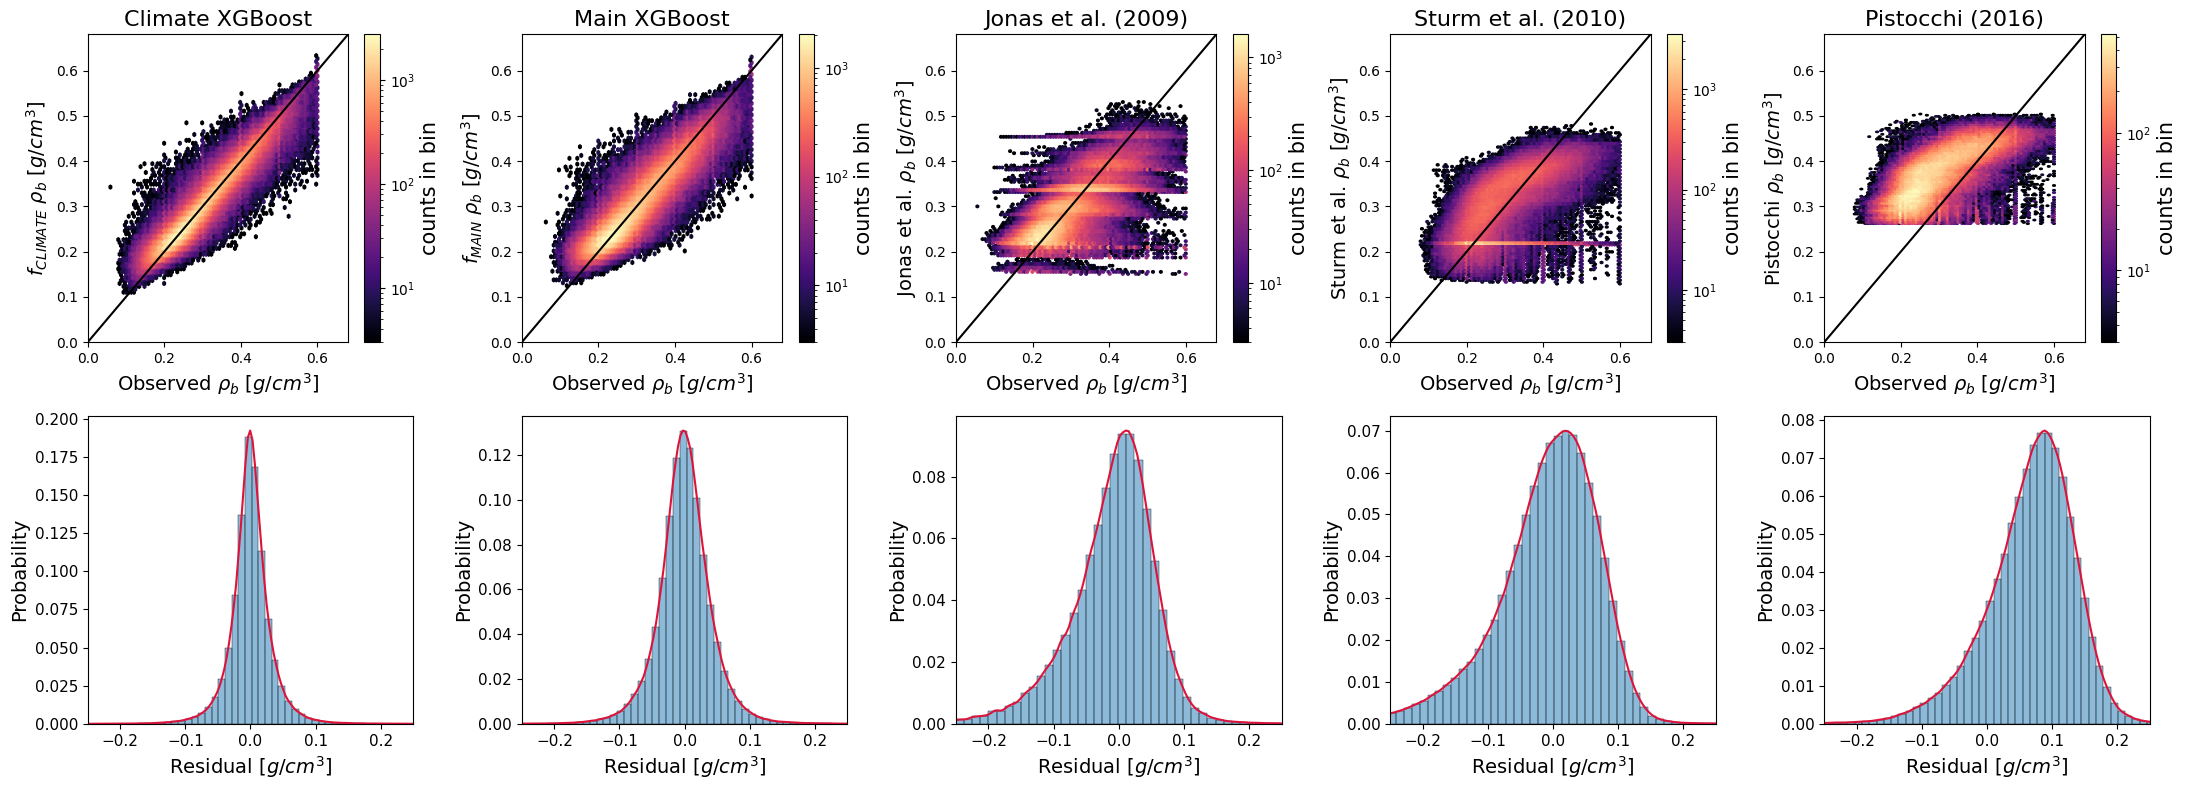

In [44]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(22, 8))

for i, model in enumerate(density_df_for_evals.columns[:-1]):
    if i >= 5:  # We only have space for 5 models in this layout
        break
        
    # Format the title based on the model name
    if model == 'XGB_Density':
        title = 'Main XGBoost'
    elif model == 'XGB_Density_climate':
        title = 'Climate XGBoost'
    elif 'Jonas' in model:
        title = 'Jonas et al. (2009)'
    elif 'Sturm' in model:
        title = 'Sturm et al. (2010)'
    elif 'Pistocchi' in model:
        title = 'Pistocchi (2016)'
    else:
        title = model.split('_')[0]
    
    # Add title to the top row (hexbin plots)
    ax[0, i].set_title(title, fontsize=16)
        
    # Hexbin plots (top row)
    hb = ax[0, i].hexbin(density_df_for_evals.Observed_Density, density_df_for_evals[model], 
                          gridsize=80, cmap='magma', bins='log', mincnt=3)
    ax[0, i].plot([0,1], [0,1], transform=ax[0, i].transAxes, color='k')
    ax[0, i].set_xlabel(r'Observed $\rho_b\ [g/cm^3]$', fontsize=14)
    
    if model == 'XGB_Density':
        y_label = r'$f_{MAIN}\ \rho_b\ [g/cm^3]$'
    elif model == 'XGB_Density_climate':
        y_label = r'$f_{CLIMATE}\ \rho_b\ [g/cm^3]$'
    elif 'Jonas' in model:
        y_label = r'Jonas et al. $\rho_b\  [g/cm^3]$'
    elif 'Sturm' in model:
        y_label = r'Sturm et al. $\rho_b\  [g/cm^3]$'
    elif 'Pistocchi' in model:
        y_label = r'Pistocchi $\rho_b\  [g/cm^3]$'
    else:
        y_label = model.split('_')[0] + r' $\rho_b\  [g/cm^3]$'
        
    ax[0, i].set_ylabel(y_label, fontsize=14)
    ax[0, i].set(xlim=(0, 0.68), ylim=(0, 0.68))
    cb = plt.colorbar(hb, ax=ax[0, i])
    cb.set_label('counts in bin', fontsize=15)

    # Histogram plots (bottom row)
    sns.histplot(density_df_for_evals[model] - density_df_for_evals.Observed_Density, 
                kde=True, stat='probability', bins=70, ax=ax[1, i])
    ax[1, i].lines[0].set_color('crimson')
    ax[1, i].set_xlabel('Residual $[g/cm^3]$', fontsize=14)
    ax[1, i].set_ylabel('Probability', fontsize=14)
    ax[1, i].set(xlim=(-0.25, 0.25))
    ax[1, i].tick_params(labelsize=11)

plt.tight_layout()
plt.savefig('../plots/figure7_presentation.jpg', dpi=300, bbox_inches='tight')
plt.show()

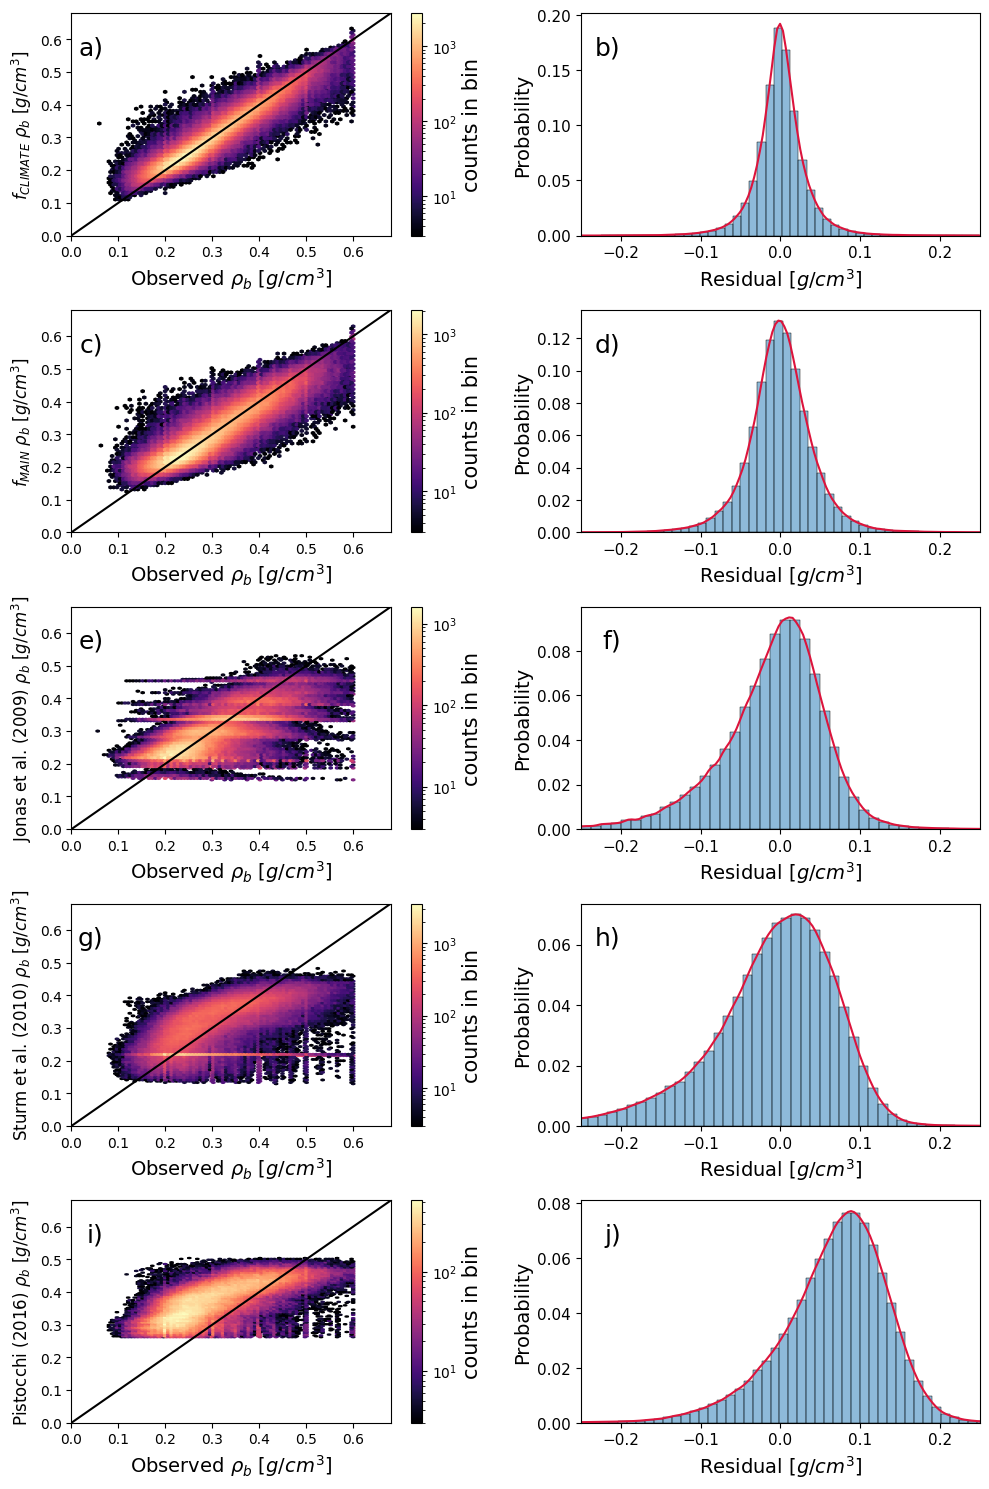

In [45]:
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(10, 15))

for i, model in enumerate(density_df_for_evals.columns[:-1]):

    if model == 'XGB_Density':
        y_label = r'$f_{MAIN}\ \rho_b\ [g/cm^3]$'
    elif model == 'XGB_Density_climate':
        y_label = r'$f_{CLIMATE}\ \rho_b\ [g/cm^3]$'
    elif 'Jonas' in model:
        y_label = 'Jonas et al. (2009)' + r' $\rho_b\  [g/cm^3]$'
    elif 'Sturm' in model:
        y_label = 'Sturm et al. (2010)' + r' $\rho_b\  [g/cm^3]$'
    elif 'Pistocchi' in model:
        y_label = 'Pistocchi (2016)' + r' $\rho_b\  [g/cm^3]$'
    else:
        y_label = model.split('_')[0] + r' $\rho_b\  [g/cm^3]$'

    hb = ax[i, 0].hexbin(density_df_for_evals.Observed_Density, density_df_for_evals[model], gridsize=80, cmap='magma', bins='log', mincnt=3)
    ax[i, 0].plot([0,1], [0,1], transform=ax[i, 0].transAxes, color='k')
    ax[i, 0].set_xlabel(r'Observed $\rho_b\ [g/cm^3]$', fontsize=14)
    ax[i, 0].set_ylabel(y_label, fontsize=12)
    ax[i, 0].set(xlim=(0, 0.68), ylim=(0, 0.68))
    ax[i, 0].text(0.10, 0.90, f'{chr(96+(2*i + 1))})', transform=ax[i, 0].transAxes, fontsize=18, va='top', ha='right')
    cb = plt.colorbar(hb)
    cb.set_label('counts in bin', fontsize=15)

    sns.histplot(density_df_for_evals[model] - density_df_for_evals.Observed_Density, kde=True, stat='probability', bins=70, ax=ax[i, 1])
    ax[i, 1].lines[0].set_color('crimson')
    ax[i, 1].set_xlabel('Residual $[g/cm^3]$', fontsize=14)
    ax[i, 1].set_ylabel('Probability', fontsize=14)
    ax[i, 1].set(xlim=(-0.25, 0.25))
    ax[i, 1].text(0.10, 0.90, f'{chr(96+(2*i + 2))})', transform=ax[i, 1].transAxes, fontsize=18, va='top', ha='right')
    ax[i, 1].tick_params(labelsize=11)

plt.tight_layout()
plt.savefig('../plots/figure7.jpg', dpi=300, bbox_inches='tight')
plt.show()

* Evaluate by Snow Class

In [46]:
for snow_class in all_density_predictions.Snow_Class.unique():

    # Filter the DataFrame for the current snow class and drop NaNs
    if snow_class != "Ephemeral":
        density_df_for_evals_ = (
            all_density_predictions.query("Snow_Class == @snow_class")
            .filter(items=[
                'XGB_Density_climate', 'XGB_Density', 'Jonas_Density', 'Sturm_Density',
                'Pistochi_Density', 'Observed_Density'
            ])
            .dropna()
        )
    else:
        density_df_for_evals_ = (
            all_density_predictions.query("Snow_Class == @snow_class")
            .filter(items=[
                'XGB_Density_climate', 'XGB_Density', 'Jonas_Density',
                'Pistochi_Density', 'Observed_Density'
            ])
            .dropna()
        )


    # Calculate the size and percentage of the test set
    size = density_df_for_evals_.shape[0]
    total_size = all_density_predictions.dropna().shape[0] + all_density_predictions.query("Snow_Class == 'Ephemeral'").drop('Sturm_Density', axis=1).dropna().shape[0]
    percentage = round(size / total_size * 100, 1)

    # Print the snow class and the size of the test set
    print(f"Snow Class: {snow_class}, Test Set Size: {size} ({percentage}%)")

    rslts=compare_multiple_models(preds_df=density_df_for_evals_, y_true="Observed_Density")

    if snow_class == "Ephemeral":
        display(rslts.assign(Sturm_Density='N/A'))
    # rslts.to_csv(f'../results/density/{snow_class}_model_eval.csv', index=True)
    # Display the results of comparing multiple models
    else:
        display(rslts)


Snow Class: Alpine, Test Set Size: 273524 (52.8%)


,XGB_Density_climate,XGB_Density,Jonas_Density,Sturm_Density,Pistochi_Density
RMSE,0.033262,0.042162,0.065143,0.070597,0.096266
MBE,0.000075,-0.000017,-0.011388,0.009828,0.071615
RSQ,0.853782,0.765067,0.439174,0.341320,-0.224732


Snow Class: Tundra, Test Set Size: 17657 (3.4%)


,XGB_Density_climate,XGB_Density,Jonas_Density,Sturm_Density,Pistochi_Density
RMSE,0.026627,0.035076,0.060338,0.070082,0.107547
MBE,0.000128,0.000362,0.014728,0.002450,0.087345
RSQ,0.901917,0.829800,0.496351,0.320559,-0.600059


Snow Class: Taiga, Test Set Size: 106115 (20.5%)


,XGB_Density_climate,XGB_Density,Jonas_Density,Sturm_Density,Pistochi_Density
RMSE,0.028171,0.035641,0.056391,0.105668,0.103977
MBE,-0.000097,-0.000181,0.014080,-0.068133,0.086853
RSQ,0.878351,0.805275,0.512550,-0.711589,-0.657242


Snow Class: Maritime, Test Set Size: 60777 (11.7%)


,XGB_Density_climate,XGB_Density,Jonas_Density,Sturm_Density,Pistochi_Density
RMSE,0.037445,0.049951,0.094334,0.078899,0.071937
MBE,0.000026,0.000221,-0.053475,-0.020589,0.006004
RSQ,0.844901,0.723990,0.015601,0.311385,0.427543


Snow Class: Prairie, Test Set Size: 43223 (8.3%)


,XGB_Density_climate,XGB_Density,Jonas_Density,Sturm_Density,Pistochi_Density
RMSE,0.033011,0.042378,0.068756,0.073183,0.092523
MBE,0.000469,0.000162,-0.015894,0.014985,0.065296
RSQ,0.861096,0.771088,0.397409,0.317323,-0.091185


Snow Class: Ephemeral, Test Set Size: 17070 (3.3%)


,XGB_Density_climate,XGB_Density,Jonas_Density,Pistochi_Density,Sturm_Density
RMSE,0.047314,0.063024,0.113153,0.087171,N/A
MBE,0.000776,0.000002,-0.069445,0.022552,N/A
RSQ,0.762653,0.578866,-0.357504,0.194341,N/A


In [47]:
density_for_boxplot=(
    all_density_predictions
    .filter(items=[
        'Observed_Density', 'XGB_Density_climate', 'XGB_Density', 'Jonas_Density', 'Sturm_Density', 'Pistochi_Density', 'Snow_Class'
    ])
    .dropna(subset=['XGB_Density_climate', 'Jonas_Density'])
    .melt(id_vars=['Snow_Class'], value_vars=['Observed_Density', 'XGB_Density_climate', 'XGB_Density', 'Jonas_Density', 'Sturm_Density', 'Pistochi_Density'], var_name='Model', value_name='Density')
    .replace({'XGB_Density_climate': '$f_{CLIMATE}$', 'XGB_Density': '$f_{MAIN}$', 'Observed_Density': 'Observed'})
)

density_for_boxplot.head()

,Snow_Class,Model,Density
0,Alpine,Observed,0.190909
1,Alpine,Observed,0.319048
2,Alpine,Observed,0.209524
3,Alpine,Observed,0.450649
4,Alpine,Observed,0.273913


#### SWE

* Overall

In [48]:
swe_df_for_evals = (
    all_swe_predictions.drop('Snow_Class', axis=1)
    .filter(items=[
        'XGB_SWE_climate', 'XGB_SWE',
        'Jonas_SWE', 'Sturm_SWE', 'Pistochi_SWE', 'Hill_SWE', 'Observed_SWE'
    ])
    .dropna()
)

swe_evals_results=compare_multiple_models(preds_df=swe_df_for_evals, y_true="Observed_SWE")
# swe_evals_results.to_csv('../results/swe/all_model_eval_results.csv', index=True)
swe_evals_results

,XGB_SWE_climate,XGB_SWE,Jonas_SWE,Sturm_SWE,Pistochi_SWE,Hill_SWE
RMSE,2.818320,3.875469,6.496382,9.414664,9.592442,11.157598
MBE,-0.010604,-0.025335,-0.193320,-0.630921,6.462173,6.526402
RSQ,0.988553,0.978355,0.939178,0.872260,0.867390,0.820585


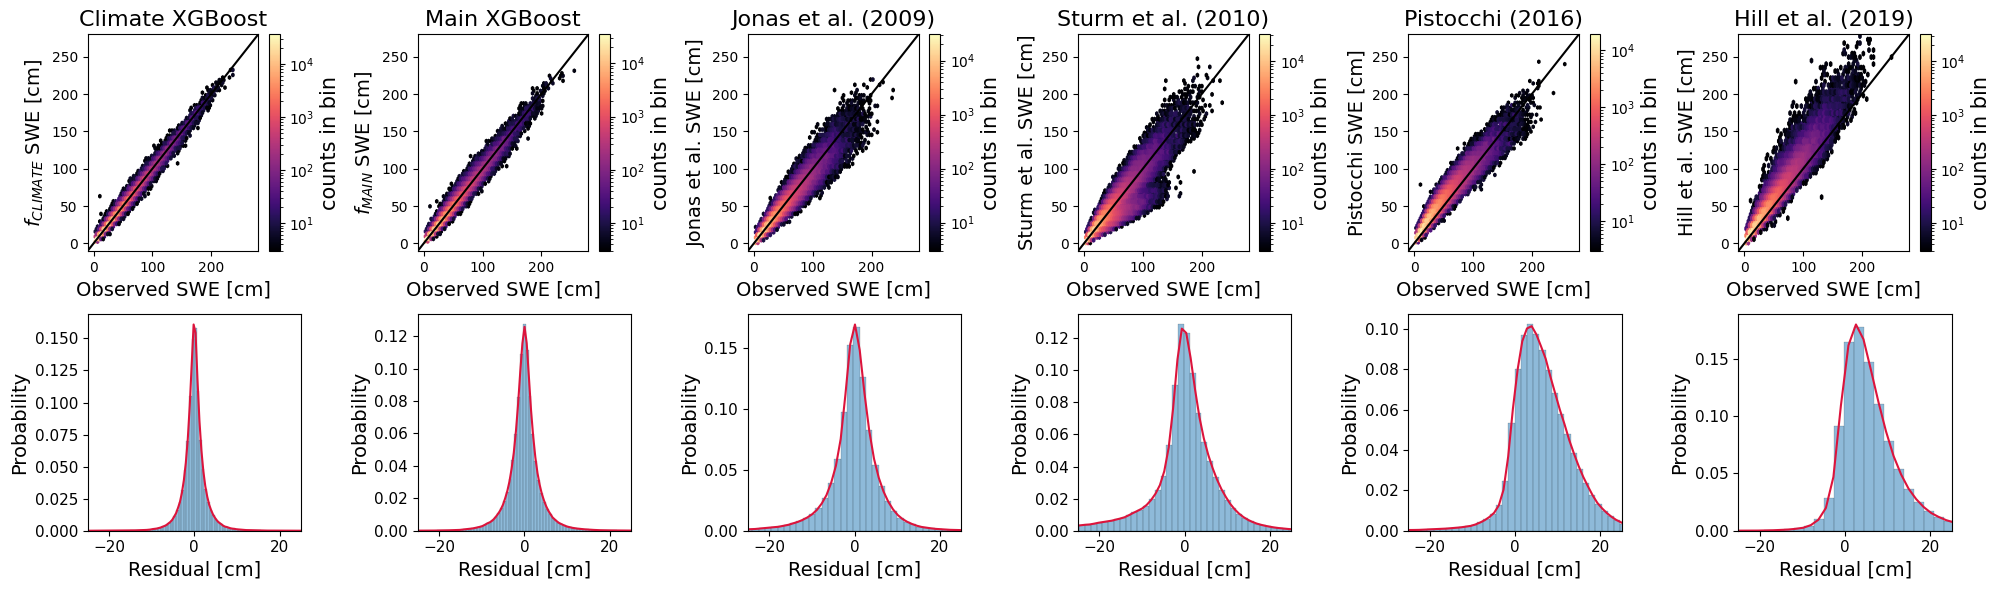

In [49]:
fig, ax = plt.subplots(nrows=2, ncols=6, figsize=(20, 6))

for i, model in enumerate(swe_df_for_evals.columns[:-1]):
    if i >= 6:  # We only have space for 6 models in this layout
        break
        
    # Format the title based on the model name
    if model == 'XGB_SWE':
        title = 'Main XGBoost'
    elif model == 'XGB_SWE_climate':
        title = 'Climate XGBoost'
    elif 'Jonas' in model:
        title = 'Jonas et al. (2009)'
    elif 'Sturm' in model:
        title = 'Sturm et al. (2010)'
    elif 'Pistochi' in model:
        title = 'Pistocchi (2016)'
    elif 'Hill' in model:
        title = 'Hill et al. (2019)'
    else:
        title = model.split('_')[0]
    
    # Add title to the top row (hexbin plots)
    ax[0, i].set_title(title, fontsize=16)
        
    # Hexbin plots (top row)
    hb = ax[0, i].hexbin(swe_df_for_evals.Observed_SWE, swe_df_for_evals[model], 
                         gridsize=80, cmap='magma', bins='log', mincnt=3)
    ax[0, i].plot([0,1], [0,1], transform=ax[0, i].transAxes, color='k')
    ax[0, i].set_xlabel('Observed SWE [cm]', fontsize=14)
    
    if model == 'XGB_SWE':
        y_label = '$f_{MAIN}$' + ' SWE [cm]'
    elif model == 'XGB_SWE_climate':
        y_label = '$f_{CLIMATE}$' + ' SWE [cm]'
    elif 'Jonas' in model:
        y_label = 'Jonas et al. SWE [cm]'
    elif 'Sturm' in model:
        y_label = 'Sturm et al. SWE [cm]'
    elif 'Pistochi' in model:
        y_label = 'Pistocchi SWE [cm]'
    elif 'Hill' in model:
        y_label = 'Hill et al. SWE [cm]'
    else:
        y_label = model.split('_')[0] + ' SWE [cm]'
        
    ax[0, i].set_ylabel(y_label, fontsize=14)
    ax[0, i].set(xlim=(-10, 280), ylim=(-10, 280))
    cb = plt.colorbar(hb, ax=ax[0, i])
    cb.set_label('counts in bin', fontsize=15)

    # Histogram plots (bottom row)
    sns.histplot(swe_df_for_evals[model] - swe_df_for_evals.Observed_SWE, 
                kde=True, stat='probability', bins=150, ax=ax[1, i])
    ax[1, i].lines[0].set_color('crimson')
    ax[1, i].set_xlabel('Residual [cm]', fontsize=14)
    ax[1, i].set_ylabel('Probability', fontsize=14)
    ax[1, i].set(xlim=(-25, 25))
    ax[1, i].tick_params(labelsize=11)

plt.tight_layout()
plt.savefig('../plots/figure8_presentation.jpg', dpi=300, bbox_inches='tight')
plt.show()

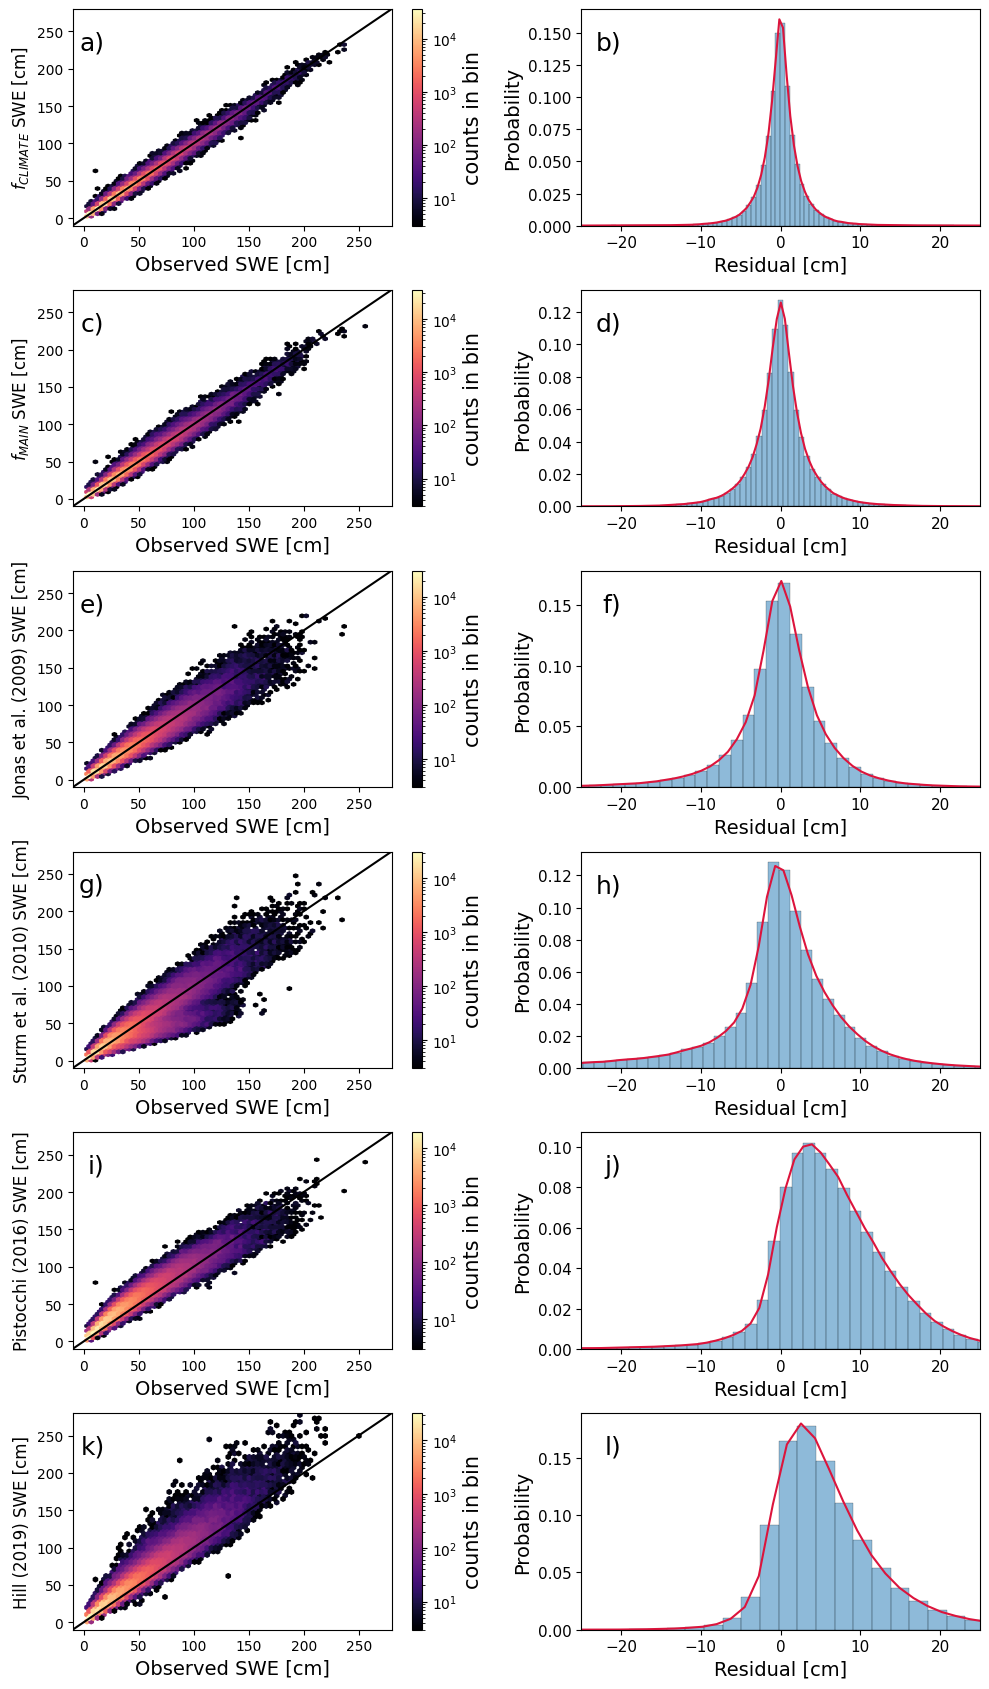

In [50]:
fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(10, 17))

for i, model in enumerate(swe_df_for_evals.columns[:-1]):

    if model == 'XGB_SWE':
        y_label = '$f_{MAIN}$' + ' SWE [cm]'
    elif model == 'XGB_SWE_climate':
        y_label = '$f_{CLIMATE}$' + ' SWE [cm]'
    elif 'Jonas' in model:
        y_label = 'Jonas et al. (2009)' + ' SWE [cm]'
    elif 'Sturm' in model:
        y_label = 'Sturm et al. (2010)' + ' SWE [cm]'
    elif 'Pistochi' in model:
        y_label = 'Pistocchi (2016)' + ' SWE [cm]' 
    elif 'Hill' in model:
        y_label = 'Hill (2019)' + ' SWE [cm]'
    else:
        y_label = model.split('_')[0] + ' SWE [cm]'

    hb = ax[i, 0].hexbin(swe_df_for_evals.Observed_SWE, swe_df_for_evals[model], gridsize=80, cmap='magma', bins='log', mincnt=3)
    ax[i, 0].plot([0,1], [0,1], transform=ax[i, 0].transAxes, color='k')
    ax[i, 0].set_xlabel('Observed SWE [cm]', fontsize=14)
    ax[i, 0].set_ylabel(y_label, fontsize=12)
    # ax[i, 0].set_aspect('equal', 'box')#.axis('equal')
    # ax[i, 0].axis('equal')
    ax[i, 0].set(xlim=(-10, 280), ylim=(-10, 280))
    ax[i, 0].text(0.10, 0.90, f'{chr(96+(2*i + 1))})', transform=ax[i, 0].transAxes, fontsize=18, va='top', ha='right')
    cb = plt.colorbar(hb)
    cb.set_label('counts in bin', fontsize=15)

    sns.histplot(swe_df_for_evals[model] - swe_df_for_evals.Observed_SWE, kde=True, stat='probability', bins=150, ax=ax[i, 1])
    ax[i, 1].lines[0].set_color('crimson')
    ax[i, 1].set_xlabel('Residual [cm]', fontsize=14)
    ax[i, 1].set_ylabel('Probability', fontsize=14)
    ax[i, 1].set(xlim=(-25, 25))
    ax[i, 1].text(0.10, 0.90, f'{chr(96+(2*i + 2))})', transform=ax[i, 1].transAxes, fontsize=18, va='top', ha='right')
    ax[i, 1].tick_params(labelsize=11)

plt.tight_layout()
plt.savefig('../plots/figure8.jpg', dpi=300, bbox_inches='tight')
plt.show()

In [51]:
for snow_class in all_swe_predictions.Snow_Class.unique():

    # Filter the DataFrame for the current snow class and drop NaNs
    if snow_class != "Ephemeral":
        swe_df_for_evals_ = (
            all_swe_predictions.query("Snow_Class == @snow_class")
            .filter(items=[
                'Observed_SWE', 'XGB_SWE_climate', 'XGB_SWE',
                'Jonas_SWE', 'Sturm_SWE', 'Pistochi_SWE', 'Hill_SWE'
            ])
            .dropna()
        )

    else:
        swe_df_for_evals_ = (
            all_swe_predictions.query("Snow_Class == @snow_class")
            .filter(items=[
                'Observed_SWE', 'XGB_SWE_climate', 'XGB_SWE',
                'Jonas_SWE', 'Pistochi_SWE', 'Hill_SWE'
            ])
            .dropna()
        )

    # Calculate the size and percentage of the test set
    size = swe_df_for_evals_.shape[0]
    total_size = all_swe_predictions.dropna().shape[0] + all_swe_predictions.query("Snow_Class == 'Ephemeral'").drop('Sturm_SWE', axis=1).dropna().shape[0]
    percentage = round(size / total_size * 100, 1)

    # Print the snow class and the size of the test set
    print(f"Snow Class: {snow_class}, Test Set Size: {size} ({percentage}%)")
    
    swe_rslts=compare_multiple_models(preds_df=swe_df_for_evals_, y_true="Observed_SWE")

    if snow_class == "Ephemeral":
        display(swe_rslts.assign(Sturm_SWE='N/A'))
    # swe_rslts.to_csv(f'../results/swe/{snow_class}_model_eval.csv', index=True)

    # Display the results of comparing multiple models
    else:
        display(swe_rslts)  

Snow Class: Alpine, Test Set Size: 261620 (56.2%)


,XGB_SWE_climate,XGB_SWE,Jonas_SWE,Sturm_SWE,Pistochi_SWE,Hill_SWE
RMSE,2.620291,3.509958,5.674952,6.346227,8.627548,8.786411
MBE,-0.009842,-0.025862,-0.454990,1.987389,6.036117,5.378028
RSQ,0.987155,0.976951,0.939748,0.924651,0.860742,0.855566


Snow Class: Tundra, Test Set Size: 16760 (3.6%)


,XGB_SWE_climate,XGB_SWE,Jonas_SWE,Sturm_SWE,Pistochi_SWE,Hill_SWE
RMSE,2.580082,3.653509,6.162744,8.350556,10.614320,8.693263
MBE,0.005445,0.032680,1.315616,-0.613344,7.830303,5.408302
RSQ,0.990215,0.980379,0.944173,0.897499,0.834391,0.888913


Snow Class: Taiga, Test Set Size: 103322 (22.2%)


,XGB_SWE_climate,XGB_SWE,Jonas_SWE,Sturm_SWE,Pistochi_SWE,Hill_SWE
RMSE,2.728117,3.662181,5.886460,14.628654,11.613387,9.738285
MBE,-0.013862,-0.026653,1.767670,-8.773785,9.132117,6.784359
RSQ,0.985927,0.974640,0.934479,0.595350,0.744971,0.820677


Snow Class: Maritime, Test Set Size: 31171 (6.7%)


,XGB_SWE_climate,XGB_SWE,Jonas_SWE,Sturm_SWE,Pistochi_SWE,Hill_SWE
RMSE,4.475357,6.654563,12.468290,11.007908,10.558025,26.170023
MBE,-0.058902,-0.067463,-4.927664,-0.208963,1.496408,17.150727
RSQ,0.988363,0.974270,0.909675,0.929595,0.935232,0.602074


Snow Class: Prairie, Test Set Size: 41223 (8.9%)


,XGB_SWE_climate,XGB_SWE,Jonas_SWE,Sturm_SWE,Pistochi_SWE,Hill_SWE
RMSE,2.723257,3.838239,6.376734,8.026980,8.547858,9.752593
MBE,0.022721,-0.010414,-0.481292,2.835289,5.672783,5.588900
RSQ,0.990972,0.982066,0.950500,0.921564,0.911054,0.884215


Snow Class: Ephemeral, Test Set Size: 11118 (2.4%)


,XGB_SWE_climate,XGB_SWE,Jonas_SWE,Pistochi_SWE,Hill_SWE,Sturm_SWE
RMSE,2.277775,3.129700,5.671410,5.006730,8.676239,N/A
MBE,-0.022866,-0.060075,-3.043455,1.812501,4.587784,N/A
RSQ,0.982563,0.967080,0.891896,0.915750,0.746999,N/A


In [52]:
swe_for_boxplot=(
    all_swe_predictions
    .filter(items=[
        'Observed_SWE', 'XGB_SWE_climate', 'XGB_SWE', 'Jonas_SWE', 'Sturm_SWE', 'Pistochi_SWE', 'Hill_SWE', 'Snow_Class'  
    ])
    .dropna(subset=['XGB_SWE_climate', 'Jonas_SWE', 'Hill_SWE'])
    .melt(id_vars=['Snow_Class'], value_vars=['Observed_SWE', 'XGB_SWE_climate', 'XGB_SWE', 'Jonas_SWE', 'Sturm_SWE', 'Pistochi_SWE', 'Hill_SWE',], var_name='Model', value_name='SWE')
    .replace({
        'XGB_SWE_climate': '$f_{CLIMATE}$', 'XGB_SWE': '$f_{MAIN}$', 'Observed_SWE': 'Observed',
        'Hill_SWE': 'Hill (2019)', 'Pistochi_SWE': 'Pistocchi (2016)', 'Sturm_SWE': 'Sturm et al. (2010)', 'Jonas_SWE': 'Jonas et al. (2009)'
    })
)

swe_for_boxplot.head()

,Snow_Class,Model,SWE
0,Alpine,Observed,16.002
1,Alpine,Observed,17.018
2,Alpine,Observed,22.352
3,Alpine,Observed,88.138
4,Alpine,Observed,20.320


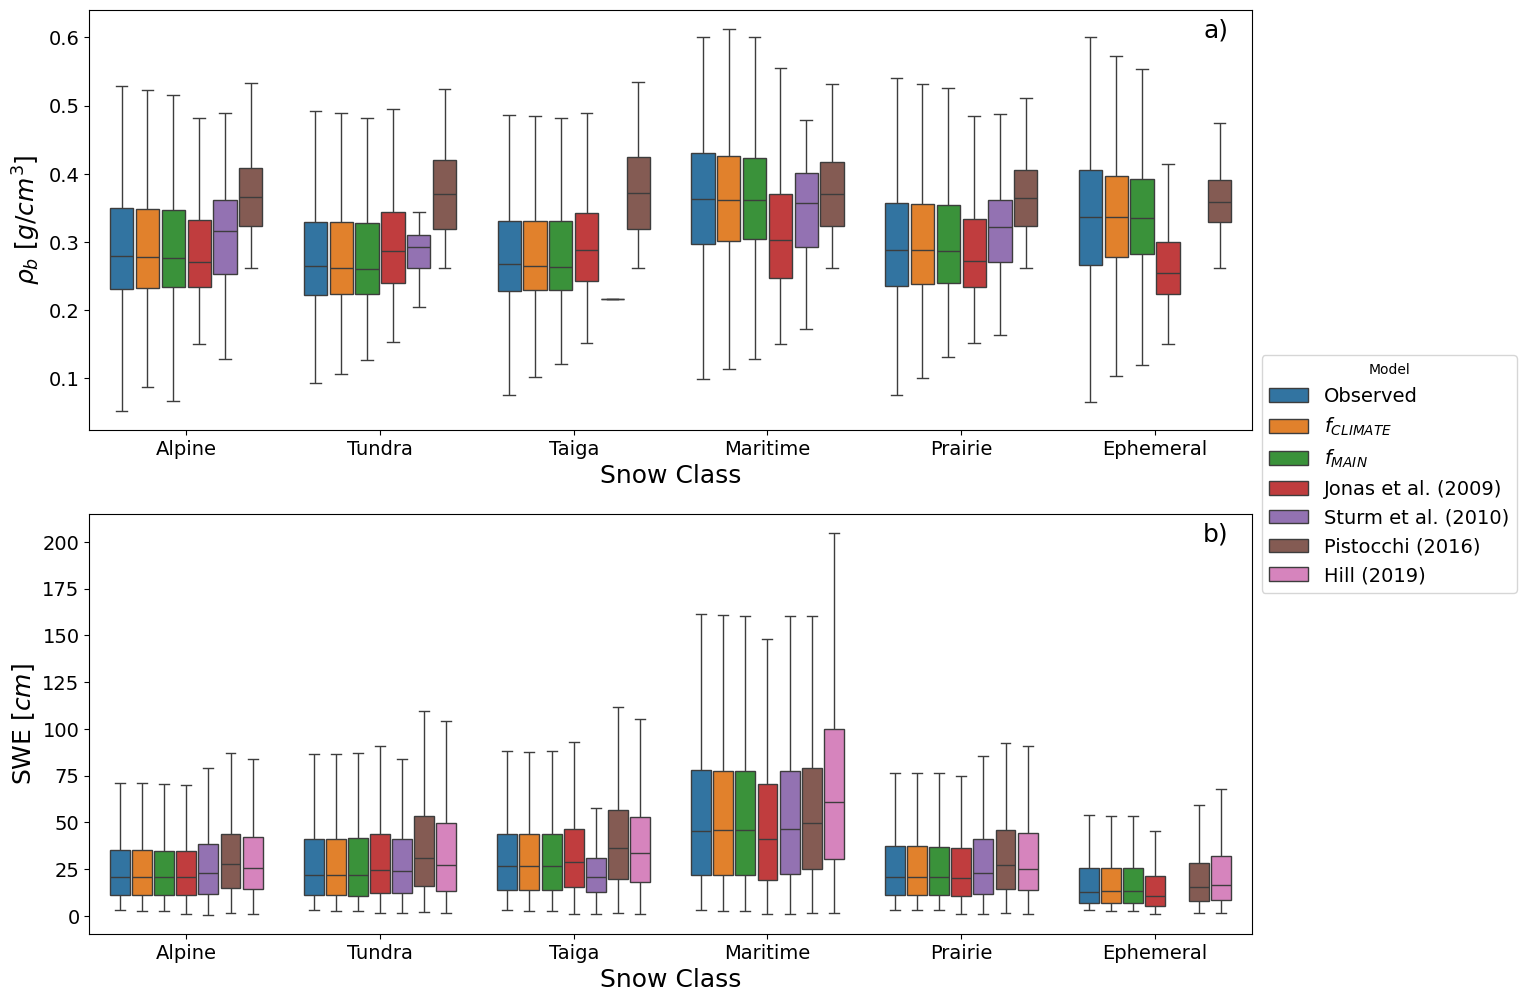

In [53]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 12))

sns.boxplot(data=density_for_boxplot, x='Snow_Class', y='Density', hue='Model', ax=ax[0], fill=True, gap=.1, showfliers = False)
ax[0].set_xlabel('Snow Class', fontsize=18)
ax[0].set_ylabel(r'$\rho_b\ [g/cm^3]$', fontsize=18)
ax[0].legend([], frameon=False)
ax[0].tick_params(labelsize=14)
# ax[0].set(ylim=(0.05, 0.60))
ax[0].text(0.98, 0.98, 'a)', transform=ax[0].transAxes, fontsize=18, va='top', ha='right')


sns.boxplot(data=swe_for_boxplot, x='Snow_Class', y='SWE', hue='Model', ax=ax[1], fill=True, gap=.1, showfliers = False)
ax[1].set_xlabel('Snow Class', fontsize=18)
ax[1].set_ylabel('SWE $[cm]$', fontsize=18)
ax[1].legend(title='Model', fontsize=14, bbox_to_anchor=(1.0, 1.4))
ax[1].tick_params(labelsize=14)
# ax[1].set(ylim=(-5, 135))
ax[1].text(0.98, 0.98, 'b)', transform=ax[1].transAxes, fontsize=18, va='top', ha='right')


plt.savefig('../plots/figure9.jpg', dpi=300, bbox_inches='tight')
plt.show()

## Feature Importance

In [54]:
xgb_main = xgb.Booster()
xgb_main.load_model("../ML_weights/main_density_model.ubj")  # Load model from Uiversal Binary JSON file

In [55]:
xgb_climate = xgb.Booster()
xgb_climate.load_model("../ML_weights/climate_density_model.ubj")

### Impurity-based Importance

In [56]:
xgboost_gain_main=(
    pd.DataFrame(
        data={
            "Feature": xgb_main.feature_names,
            "Importance": xgb_main.get_score(importance_type='gain').values()
        }
    )
    .sort_values(by="Importance", ascending=False)
    .replace({
        'Snow_Class': 'Snow Class',
        'Snow_Depth': 'Snow Depth',

    })
)

xgboost_gain_main

,Feature,Importance
3,Snow Class,0.240515
2,DOWY,0.114483
0,Elevation,0.030825
1,Snow Depth,0.024226


In [58]:
xgboost_gain_climate=(
    pd.DataFrame(
        data={
            "Feature": xgb_climate.feature_names,
            "Importance": xgb_climate.get_score(importance_type='gain').values()
        }
    )
    .sort_values(by="Importance", ascending=False)
    .replace({
        'Snow_Class': 'Snow Class',
        'Snow_Depth': 'Snow Depth',
        'TAVG_lag_14d': r'$\bar{t}_{-14}$',
        'PRECIPITATION_lag_14d': r'$\bar{p}_{-14}$'
    })
)

xgboost_gain_climate

,Feature,Importance
5,Snow Class,0.070327
2,DOWY,0.053497
1,Snow Depth,0.014610
3,$\bar{t}_{-14}$,0.011647
0,Elevation,0.010552
4,$\bar{p}_{-14}$,0.005069


### SHAP Importance

In [60]:
X_train_raw = data_splits['X_temp'] # train + val instances
X_test_raw = data_splits['X_test']
y_train = data_splits['y_temp']
y_test = data_splits['y_test']

In [61]:
with open('../ML_weights/encoder.pkl', 'rb') as f:
    loaded_encoder = pickle.load(f)

# Use the loaded encoder
new_X_cat = loaded_encoder.transform(X_test_raw['Snow_Class'])
X_test_main = pd.concat([X_test_raw[['Elevation', 'Snow_Depth', 'DOWY']], new_X_cat], axis=1)

In [62]:
## Calculate SHAP values for the density model
xgb_main.set_param({"device": "cuda:0"}) ## comment this oit if you do not have a GPU
explainer = shap.TreeExplainer(xgb_main)
shap_values_main = explainer.shap_values(X_test_main)

In [63]:
shap_importance_main=(
    pd.DataFrame(
        data={
            "Feature": xgb_main.feature_names,
            "Importance": np.abs(shap_values_main).mean(axis=0)
        }
    )
    .sort_values(by="Importance", ascending=False)
    .replace({
        'Snow_Class': 'Snow Class',
        'Snow Depth': 'Snow Depth',
    })
)

shap_importance_main

,Feature,Importance
2,DOWY,0.054588
0,Elevation,0.016786
3,Snow Class,0.015857
1,Snow_Depth,0.013277


In [64]:
with open('../ML_weights/encoder_climate.pkl', 'rb') as f:
    loaded_encoder_climate = pickle.load(f)


X_test_raw_climate=X_test_raw.dropna(subset = ['TAVG_lag_14d', 'PRECIPITATION_lag_14d'])

# Use the loaded encoder
new_X_cat_climate = loaded_encoder_climate.transform(X_test_raw_climate['Snow_Class'])
X_test_climate = pd.concat([X_test_raw_climate[['Elevation', 'Snow_Depth', 'DOWY','TAVG_lag_14d', 'PRECIPITATION_lag_14d']], new_X_cat_climate], axis=1)

In [65]:
## Calculate SHAP values for the density model
xgb_climate.set_param({"device": "cuda:3"}) ## comment this oit if you do not have a GPU
explainer = shap.TreeExplainer(xgb_climate)
shap_values_climate = explainer.shap_values(X_test_climate)

In [67]:
shap_importance_climate=(
    pd.DataFrame(
        data={
            "Feature": xgb_climate.feature_names,
            "Importance": np.abs(shap_values_climate).mean(axis=0)
        }
    )
    .sort_values(by="Importance", ascending=False)
    .replace({
        'Snow_Class': 'Snow Class',
        'Snow_Depth': 'Snow Depth',
        'TAVG_lag_14d': r'$\bar{t}_{-14}$',
        'PRECIPITATION_lag_14d': r'$\bar{p}_{-14}$'
    })
)

shap_importance_climate

,Feature,Importance
2,DOWY,0.045380
3,$\bar{t}_{-14}$,0.018629
1,Snow Depth,0.016800
5,Snow Class,0.011944
0,Elevation,0.011691
4,$\bar{p}_{-14}$,0.005920


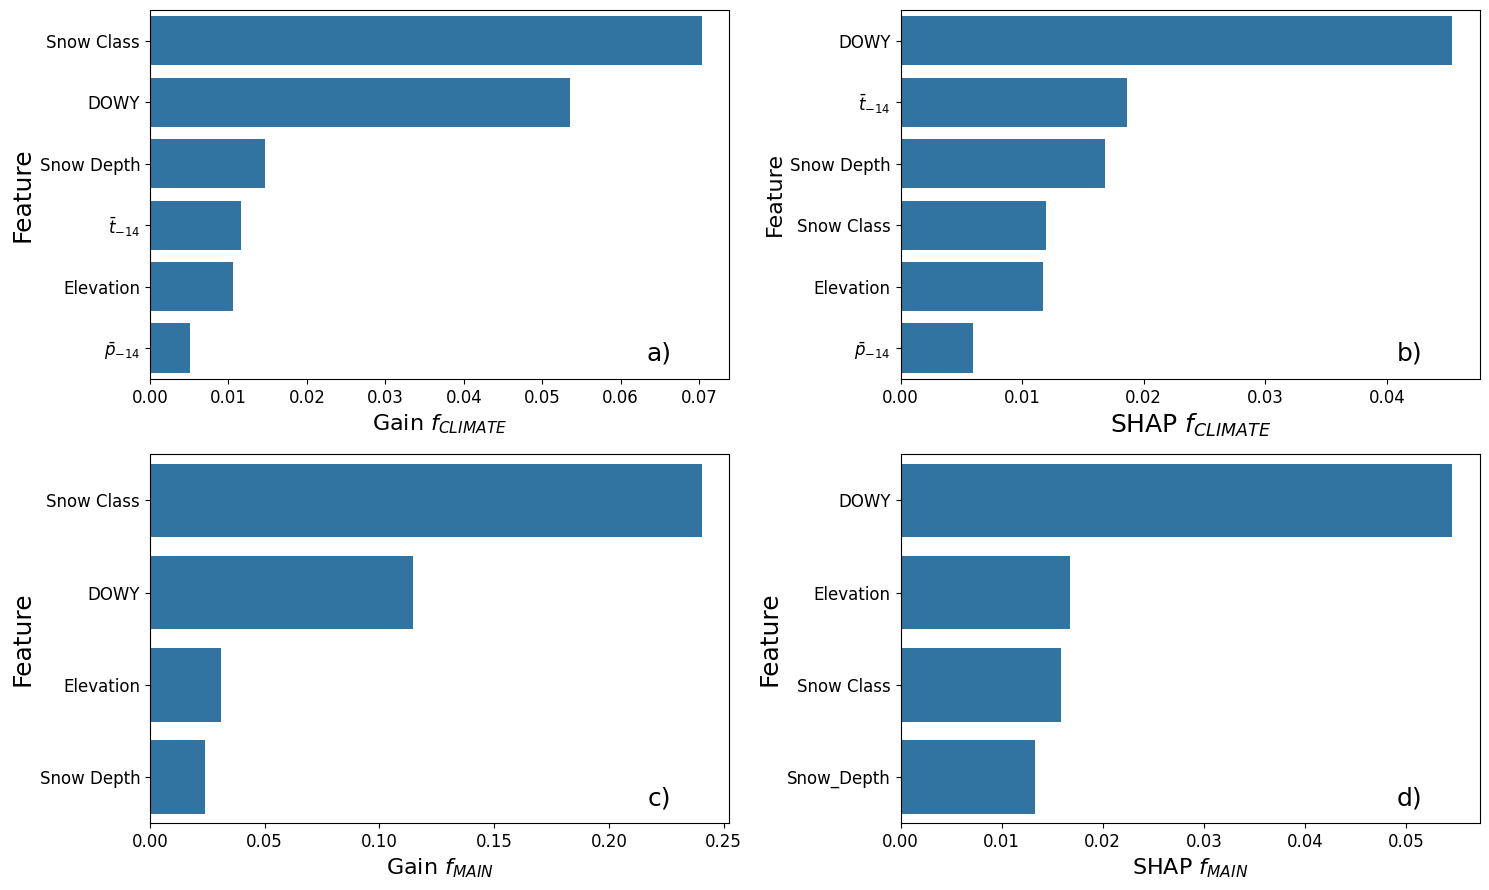

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 9))

sns.barplot(x="Importance", y="Feature", data=xgboost_gain_climate, ax=ax[0, 0])
ax[0, 0].set_xlabel("Gain $f_{CLIMATE}$", fontsize=16)
ax[0, 0].set_ylabel("Feature", fontsize=18)
ax[0, 0].tick_params(labelsize=12)
ax[0, 0].text(0.90, 0.10, 'a)', transform=ax[0, 0].transAxes, fontsize=18, va='top', ha='right')



sns.barplot(x="Importance", y="Feature", data=shap_importance_climate, ax=ax[0, 1])
ax[0, 1].set_xlabel("SHAP $f_{CLIMATE}$", fontsize=18)
ax[0, 1].set_ylabel("Feature", fontsize=16)
ax[0, 1].tick_params(labelsize=12)
ax[0, 1].text(0.90, 0.10, 'b)', transform=ax[0, 1].transAxes, fontsize=18, va='top', ha='right')



sns.barplot(x="Importance", y="Feature", data=xgboost_gain_main, ax=ax[1, 0])
ax[1, 0].set_xlabel("Gain $f_{MAIN}$", fontsize=16)
ax[1, 0].set_ylabel("Feature", fontsize=18)
ax[1, 0].tick_params(labelsize=12)
ax[1, 0].text(0.90, 0.10, 'c)', transform=ax[1, 0].transAxes, fontsize=18, va='top', ha='right')



sns.barplot(x="Importance", y="Feature", data=shap_importance_main, ax=ax[1, 1])
ax[1, 1].set_xlabel("SHAP $f_{MAIN}$", fontsize=16)
ax[1, 1].set_ylabel("Feature", fontsize=18)
ax[1, 1].tick_params(labelsize=12)
ax[1, 1].text(0.90, 0.10, 'd)', transform=ax[1, 1].transAxes, fontsize=18, va='top', ha='right')

plt.tight_layout()
plt.savefig('../plots/figure10.jpg', dpi=300, bbox_inches='tight')
plt.show()